# DATA2001 S1 2021 Practical Assignment - Bushfire Risk Analysis (Notebook)
*An analysis of neighbourhood fire risk and median income & rent.*

**Assignment Group F14 - 3**

**Eugene Ward (SID: 311193781) & Matthew Shu (SID: 500445930)**

---

## Setup: Import libraries and create functions

In [2]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np

import requests
import json

from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Eugene uses this
def pgconnect_using_credfile(credential_filepath):
    try:
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgres+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

# Function for querying the PostgreSQL DB.
# Returns value and a converted dataframe (SOURCE: DATA2001 Lab materials)
def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

# WKT point geom creation function (SOURCE: DATA2001 Lab materials)
def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid)

# WKT polygon geom creation function (SOURCE: DATA2001 Lab materials)
# Adapted to handle conversion of empty geometries
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    elif (geom.geom_type == 'GeometryCollection'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# Z-score
def z(x, avg, sd):
    return((x-avg)/sd)

# Sigmoidal function. Did not use native exponential because fails for large negative values.
def sigmoid(x):
    return(1/(1+np.exp(-x)))

# Created and add z-score column for measure
def add_z_score_column(df, **kwargs):
    column = [c for c in df.columns.tolist() if 'density' in c][0] #Finds relevant column to calculate Z-score on
    if kwargs.get('column'):
        column = kwargs.get('column')
    mean = np.mean(df[column])
    std = np.std(df[column])
    df['z_score'] = df[column].map(lambda x: z(x, mean, std))
    return df

# Generate correlation matrix
def CorrHeatmap(df, X):
    cor = df[['fire_risk_score', X]].corr() #Native pandas correlation
    sns.heatmap(cor, annot=True)
    plt.title('Correlation')
    plt.show()

# Generate scatter chart with LM line
def LinearRegGraph(reg, y_array, X_array, X):
    plt.scatter(X_array, y_array)
    y_pred = reg.predict(X_array)
    plt.plot(X_array, y_pred)
    plt.xlabel('{X}'.format(X=X))
    plt.ylabel('Fire Risk Score')
    plt.title('Fire Risk Score regressed on {X}'.format(X=X))
    plt.show()

# Generate residuals plot
def Residual(reg, y_array, X_array, X): #Condition for creating a residual plot
    y_pred = reg.predict(X_array)
    res = y_array-y_pred
    plt.scatter(y_pred, res)
    plt.xlabel('Predicted values for {X}'.format(X=X))
    plt.ylabel('Residuals')
    plt.title('Residuals for {X}'.format(X=X))
    plt.axhline(color='r')
    plt.show()

# Generate OLS details and test values
def Stats(df, y_array, X_array):
    X2 = sm.add_constant(X_array)
    mod = sm.OLS(y_array, X2)
    res = mod.fit()
    print(res.summary())
    
# Generate all correlation analyses for values returned from our database, using functions defined above
def LinearReg(y, X):
    query = """SELECT area_id, fire_risk_score, {X} FROM neighbourhoods INNER JOIN fire_risk USING(area_id);""".format(X=X)
    response, df = pgquery(conn, query)
    df = df.dropna() #Drop rows with NaN median income and monthly rent
    print(df)
    y_array = np.array(df.loc[:,y])
    X_array = np.array(df.loc[:, X]).reshape(-1,1) #Sklearn requires multidimensional
    reg = LinearRegression().fit(X_array,y_array)
    Residual(reg, y_array, X_array, X)
    LinearRegGraph(reg, y_array, X_array, X)
    Stats(df, y_array, X_array)
    CorrHeatmap(df,X)
    return reg

print("Setup successful. Libraries imported and functions ready.")

Setup successful. Libraries imported and functions ready.


In [2]:
# ------ Internal use MATTHEW
#For troubleshooting in the case your data isn't loading.
#os.chdir('M:\\Jupyter Notebooks\\data2001_project')
#os.getcwd()

## Task 1: Data Integration and Database Generation

The 3 provided CSV files and 2 provided shapfiles are loaded in as dataframes/geodataframes, inspected and cleaned. We are also making use of one additional dataset, retrieved from a Geoscience Australia Web Service and converted to a geodataframe.

### Loading datasets (standard dataframes)

#### *Statistical Areas*

In [3]:
stat_areas_df = pd.read_csv('./data/StatisticalAreas.csv')
print(stat_areas_df.dtypes)

# Cleaning - remove duplicates
print(len(stat_areas_df.area_id.unique()))

# DUPLICATE ROWS in statisticalareas - confirmed
#print(stat_areas_df.area_id.value_counts())
#stat_areas_df.loc[stat_areas_df['area_id']==106]
#stat_areas_df.loc[stat_areas_df['area_id']==111]
#stat_areas_df.loc[stat_areas_df['area_id']==114]

print(len(stat_areas_df))
stat_areas_df = stat_areas_df.drop_duplicates()
print(len(stat_areas_df))

stat_areas_df.head(2)

area_id            int64
area_name         object
parent_area_id     int64
dtype: object


#### *Neighbourhoods*

In [ ]:
nbhd_df = pd.read_csv('./data/Neighbourhoods.csv')

#nbhd_df.area_id.value_counts() # confirmed no duplicate area_id

# Changing column names according to assignment sheet
nbhd_df = nbhd_df.rename(columns={'number_of_dwellings':'dwellings', 'number_of_businesses':'businesses', 'median_annual_household_income':'median_income'}) 

print(len(nbhd_df))
print(nbhd_df.dtypes)

# Cleaning - correcting number representations
nbhd_df['population'] = nbhd_df['population'].str.replace(',','')
nbhd_df['population'] = nbhd_df['population'].astype('float64')

nbhd_df['dwellings'] = nbhd_df['dwellings'].str.replace(',','')
nbhd_df['dwellings'] = nbhd_df['dwellings'].astype('float64')

# Note: NaN values present in neighbourhoods
# Decision - interpet NaN as 0
print(len(nbhd_df[nbhd_df.isna().any(axis=1)]))
nbhd_df[nbhd_df.isna().any(axis=1)]

#### *Business Stats*

In [9]:
busi_stat_df = pd.read_csv('./data/BusinessStats.csv')

busi_stat_df = busi_stat_df.drop(columns=['area_name']) #Not in the required columns according to May revision of assigment sheet v3
busi_stat_df = busi_stat_df.rename(columns={'accommodation_and_food_services':'accommodation_and_food'}) #Changing column names according to assignment sheet

#busi_stat_df.area_id.value_counts() # confirmed no duplicates
print(len(busi_stat_df))
print(busi_stat_df.dtypes)

# DB DESIGN DECISION: LIMIT BUSINESS STAT OBSERVATIONS IN DB TO THE NEIGHBOURHOODS STUDIED

print(len(busi_stat_df))
busi_stat_df = busi_stat_df.loc[busi_stat_df['area_id'].isin(nbhd_df['area_id'].tolist())]
print(len(busi_stat_df))

# Note: No NAN values present in businessstats
busi_stat_df[busi_stat_df.isna().any(axis=1)]

2301
area_id                              int64
number_of_businesses                 int64
accommodation_and_food               int64
retail_trade                         int64
agriculture_forestry_and_fishing     int64
health_care_and_social_assistance    int64
public_administration_and_safety     int64
transport_postal_and_warehousing     int64
dtype: object


In [10]:
# DECISION: cast area_id in each df as string in order to ensure integrity going into DB as non-numeric values
stat_areas_df['area_id'] = stat_areas_df['area_id'].astype('str')
print(stat_areas_df['area_id'].dtype)

nbhd_df['area_id'] = nbhd_df['area_id'].astype('str')
print(nbhd_df['area_id'].dtype)

busi_stat_df['area_id'] = busi_stat_df['area_id'].astype('str')
print(busi_stat_df['area_id'].dtype)

object
object
object


### Loading datasets (geodataframes)
#### RFS NSW Bushfire Prone Land - shapefile

In [ ]:
rfs_gdf = gpd.read_file('./data/RFSNSW_BFPL/RFSNSW_BFPL.shp')
print(rfs_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94
rfs_gdf.columns = [x.lower() for x in rfs_gdf.columns] # lower case col names
print(rfs_gdf.dtypes)

# Check geometries
print(len(rfs_gdf))
rfs_gdf.geometry.type.value_counts()

# Recreate incrementing 'gid' (0 index)
rfs_gdf.insert(loc=0, column='gid', value=rfs_gdf.index)
rfs_gdf.head()

#### ABS Statistical Area 2 (2016) - shapefile

In [16]:
sa2_gdf = gpd.read_file('./data/1270055001_sa2_2016_aust_shape/SA2_2016_AUST.shp')

print(sa2_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94

sa2_gdf.columns = [x.lower() for x in sa2_gdf.columns] # lower case col names

# Recreate incrementing 'g_id' (0 index)
sa2_gdf.insert(loc=0, column='g_id', value=sa2_gdf.index)

# Changing column names according to assignment sheet
sa2_gdf=sa2_gdf.rename(columns={'sa3_code16':'sa3_code', 'sa3_name16':'sa3_name', 'sa4_code16':'sa4_code', 'sa4_name16':'sa4_name', 'gcc_code16':'gcc_code', 'gcc_name16':'gcc_name', 'ste_code16':'ste_code', 'ste_name16':'ste_name'})

sa2_gdf['sa2_main16'] = sa2_gdf['sa2_main16'].astype('str')

sa2_gdf.head(1)

epsg:4283


,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geometry
0,0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."


In [17]:
# Check geometries
print(len(sa2_gdf))
print(sa2_gdf.geometry.type.value_counts())
no_geoms_sa2 = sum(sa2_gdf.geometry.type.isna())
print(f'Null geometry count: {no_geoms_sa2}')

2310
Polygon         2083
MultiPolygon     209
dtype: int64
Null geometry count: 18


In [18]:
# Inspection / preliminary exploration
print(sa2_gdf.ste_name.value_counts()) # Confirm federal level dataset
print("\n")
print(sa2_gdf.loc[sa2_gdf.ste_name=="New South Wales"]['gcc_name'].value_counts()) # Confirm Greater Sydney GCCSA

# Process to support report writing - confirm GS vs RONSW split of provided neighbourhoods
nbhd_join_sa2 = pd.merge(nbhd_df, sa2_gdf, left_on='area_id', right_on='sa2_main16')
print('\n')
print(nbhd_join_sa2.gcc_name.value_counts()) # 312 GS and 10 RONSW
print("\nThe assignment involves devising risk scores for all 312 Greater Sydney SA2s\nand the following 10 other NSW SA2s:\n")
nbhd_join_sa2.loc[nbhd_join_sa2.gcc_name == "Rest of NSW"]['area_name'].to_list()

New South Wales                 578
Queensland                      530
Victoria                        464
Western Australia               254
South Australia                 174
Australian Capital Territory    133
Tasmania                        101
Northern Territory               70
Other Territories                 6
Name: ste_name, dtype: int64


Greater Sydney                           312
Rest of NSW                              264
Migratory - Offshore - Shipping (NSW)      1
No usual address (NSW)                     1
Name: gcc_name, dtype: int64


Greater Sydney    312
Rest of NSW        10
Name: gcc_name, dtype: int64

The assignment involves devising risk scores for all 312 Greater Sydney SA2s
and the following 10 other NSW SA2s:



['Goulburn Region',
 'Bathurst Region',
 'Oberon',
 'Lithgow',
 'Lithgow Region',
 'Cessnock Region',
 'Singleton Region',
 'Morisset - Cooranbong',
 'Hill Top - Colo Vale',
 'Southern Highlands']

In [19]:
# DECISION: WE RETAIN THE 18 ROWS WHERE NO SPATIAL JOINS OR FUNCTIONS CAN BE PERFORMED (NULL GEOMETRIES)
# TO MAINTAIN FULL SA2 SHAPEFILE IN OUR DB

### Additional dataset: Telephone Exchanges NSW
#### Geodataframe created from a retrieved JSON from ArcGIS REST Web Service provided by Geoscience Australia
Open API - credentials are not required to run the request.

EPSG:
{'wkid': 4283, 'latestWkid': 4283}


,name,geometry
574,Wooli,POINT (153.25366 -29.80452)
575,Wisemans Ferry,POINT (150.98660 -33.38578)
576,Werombi,POINT (150.57313 -33.97689)
577,Maraylya,POINT (150.91293 -33.59606)
578,Kemps Creek,POINT (150.82714 -33.87712)


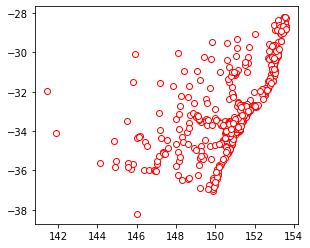

In [45]:
# Geoscience Australia - National Telephone Exchanges ArcGIS REST Web Service (Open API - no key required)
# https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0
# Usage permitted under Creative Commons Attribution 4.0 International Licence

# This service requires a relational model style syntax for its parameters, 
# e.g. WHERE (STATE)='New South Wales'
# These params then need to be converted to URL encoded characters for making the endpoint GET request

# We query the active communications exchanges in New South Wales to form our additional dataset
# with parameter: format = json

query_param = "%28STATE%29%3D%27New+South+Wales%27" # (STATE)='New South Wales'
response = requests.get("https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0/query?where="+
                        query_param+
                        "&f=json")

assert response.status_code == 200

exchanges_json = response.json()

# We have inspected the full JSON result in previous requests and deploy the keys accordingly

print('EPSG:\n' + str(exchanges_json['spatialReference'])) # Confirmed GDA94

# Convert results to pandas dataframe
names_recs = []
longs = []
lats = []

for i in range(0, len(exchanges_json['features'])):
    item_name = exchanges_json['features'][i]['attributes']['name']
    item_long = exchanges_json['features'][i]['geometry']['x']
    item_lat = exchanges_json['features'][i]['geometry']['y']
    names_recs.append(item_name)
    longs.append(item_long)
    lats.append(item_lat)

names_series = pd.Series(names_recs)
longs_series = pd.Series(longs)
lats_series = pd.Series(lats)

exchanges_df = pd.DataFrame({'name': names_series, 'longitude': longs_series,
                            'latitude': lats_series})

# Convert the df to geodataframe where longitude and latitude are combined into POINT geometries
exchanges_gdf = gpd.GeoDataFrame(exchanges_df,
                                       geometry=gpd.points_from_xy(exchanges_df.longitude, exchanges_df.latitude))

exchanges_gdf = exchanges_gdf.drop(columns=['longitude', 'latitude'])
exchanges_gdf.plot(color='white', edgecolor='red')

exchanges_gdf.tail()

In [56]:
# According to the service, the point that appears to be in Victoria is Dareton, which is a border town (in NSW)
exchanges_df.loc[exchanges_df['latitude'] < -38]

# The coordinates are likely an error but this town would not be in the analysis anyway
# The row is retained in the DB design.

,name,longitude,latitude,geometry
547,Dareton,146.002434,-38.199966,POINT (146.00243 -38.19997)


---

### Connecting with Database and Creation of Tables
#### *Running connection function with credentials*

#### **ATTN MARKER - DO *NOT* RUN** cell below

In [5]:
### ---------------ATTN MARKER - DO *NOT* RUN---------------
# Alternative Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Matthew
# JUST FOR MATTHEW

def pgconnect_using_credfile(credential_filepath):
    try:
        args = {
            'sslmode':'disable',
            'gssencmode':'disable'
        }
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgresql+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False, connect_args=args)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

### CONNECT:

In [3]:
# Connect to University server student Postgres DB. 
# This function will not work if not on campus or if not connected to VPN.

credfilepath = './data2x01_db.json' # Internal note: not tracked on Git, must be locally available. 
# Eugene's credentials JSON to be uploaded in submission

db, conn = pgconnect_using_credfile(credfilepath)

connected


#### *Test connection and functions with PostGIS (Postgres geospatial plugin) check*

In [23]:
# Checking we have PostGIS working on our connection (SOURCE: DATA2001 Lab materials)

postgis_check = '''
SELECT PostGIS_Version();
'''

retval,retdf = pgquery(conn,postgis_check)
retdf

(1, 1)
                         postgis_version
0  3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Creation of Database Tables (from dataframes)

In [57]:
# Check existing tables in Postgres DB public schema
for table in db.table_names():
    print(f'{table}\n')

spatial_ref_sys

neighbourhoods

sa2_2016_aust

exchanges

businessstats

fire_risk

rfsnsw_bfpl

statisticalareas



#### Considering set relationships between datasets for key designations

In [25]:
# Establishing set relationships between tables
test_df = stat_areas_df.copy() # 431 unique area_ids exist in statisticalareas
subset = set(nbhd_df.area_id.unique()) # 322 unique area_ids exist in neighbourhoods
test_df['exists'] = stat_areas_df.area_id.map(lambda x : True if x in subset else False)
test_df['exists'].value_counts()

# Statisticalareas contains a set of area_ids of which the set of neighbourhoods area_id values is a subset 
# (It is a PK in its own table and an FK in relation to statisticalareas)

# Note that there exists one more SA2 length ID in statisticalareas and that these 323 SA2s exist in the shapefile
sa2s_in_statareas = stat_areas_df.loc[stat_areas_df['area_id'].str.len() == 9]
sa2s_in_statareas.loc[~sa2s_in_statareas.area_id.isin(nbhd_df['area_id'].tolist())]

True     322
False    109
Name: exists, dtype: int64

In [27]:
# The 323 SA2s in statisticalareas are a subset of the national SA2 shapefile attribute sa2_main16
# A foreign key relationship from area_id in both neighbourhoods and statisticalareas 
# to sa2_main16 would be appropriate *IF* sa2_main16 were a primary key, however
# g_id has been designated PK; it is preferable that the 'area_id' meaning
# is preserved as definitive in the context where it can include other levels of statistical area (statisticalareas)

sa2s_in_statareas = stat_areas_df.loc[stat_areas_df['area_id'].str.len() == 9]
print(len(sa2s_in_statareas))

test_df2 = sa2_gdf.copy()
subset2 = set(sa2s_in_statareas.area_id.unique())
test_df2['exists'] = sa2_gdf.sa2_main16.map(lambda x : True if x in subset2 else False)
test_df2['exists'].value_counts()

# Finally, from a cleaning step which masked businessstats with neighbourhoods area_ids, 
# we know that businessstats will hold the same key relationships with statisticalareas as neighbourhoods

323


False    1987
True      323
Name: exists, dtype: int64

#### Statistical Areas

In [28]:
conn.execute("DROP TABLE IF EXISTS statisticalareas")

stat_areas_create = '''CREATE TABLE statisticalareas (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     parent_area_id VARCHAR NOT NULL,
                     CONSTRAINT statisticalareas_pkey PRIMARY KEY (area_id)
                     )'''

conn.execute(stat_areas_create)

In [29]:
# Insert df data
stat_areas_df.to_sql('statisticalareas', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM statisticalareas
LIMIT 1;""")
a_df.head()

Data inserted into Table
(1, 3)
  area_id        area_name parent_area_id
0       1  New South Wales              0


,area_id,area_name,parent_area_id
0,1,New South Wales,0


#### Neighbourhoods

In [30]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods")

neighbourhoods_create = '''CREATE TABLE neighbourhoods (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     land_area FLOAT NOT NULL,
                     population NUMERIC,
                     dwellings NUMERIC NOT NULL,
                     businesses NUMERIC,
                     median_income NUMERIC,
                     avg_monthly_rent NUMERIC,
                     CONSTRAINT neighbourhoods_pkey PRIMARY KEY (area_id),
                     CONSTRAINT neighbourhoods_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

# ALLOW NULL for 'population' 'businesses' avg_monthly_rent' 'median_income'

conn.execute(neighbourhoods_create)

In [31]:
# Insert df data
nbhd_df.to_sql('neighbourhoods', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM neighbourhoods
LIMIT 1;""")
a_df.head()

Data inserted into Table
(1, 8)
     area_id                 area_name  land_area  population  dwellings  businesses  median_income  avg_monthly_rent
0  102011028  Avoca Beach - Copacabana      643.8      7590.0     2325.0       738.0        46996.0            1906.0


,area_id,area_name,land_area,population,dwellings,businesses,median_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8,7590.0,2325.0,738.0,46996.0,1906.0


#### Business Stats

In [32]:
conn.execute("DROP TABLE IF EXISTS businessstats")

business_create = '''CREATE TABLE businessstats (
                     area_id VARCHAR NOT NULL,
                     number_of_businesses NUMERIC NOT NULL,
                     accommodation_and_food NUMERIC NOT NULL,
                     retail_trade NUMERIC NOT NULL,
                     agriculture_forestry_and_fishing NUMERIC NOT NULL,
                     health_care_and_social_assistance NUMERIC NOT NULL,
                     public_administration_and_safety NUMERIC NOT NULL,
                     transport_postal_and_warehousing NUMERIC NOT NULL,
                     CONSTRAINT businessstats_pkey PRIMARY KEY (area_id),
                     CONSTRAINT businessstats_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

conn.execute(business_create)

In [33]:
# Insert df data
busi_stat_df.to_sql('businessstats', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM businessstats
LIMIT 1;""")
a_df.head()

Data inserted into Table
(1, 1)
   count
0    322


### Creation of Database Tables (from geodataframes)

#### RFS NSW Bushfire Prone Land - shapefile

In [35]:
srid = 4283
rfs_gdf['geom'] = rfs_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
rfs_gdf = rfs_gdf.drop(columns="geometry")
rfs_gdf.head()

,gid,category,shape_leng,shape_area,geom
0,0,1,0.000017,5.392400e-12,POINT (149.1131894786667 -33.05824346699998)
1,1,1,0.000178,1.140005e-09,POINT (152.2753625074807 -29.68315654934266)
2,2,1,0.000890,4.950178e-08,POINT (152.1424400005001 -29.68265650149996)
3,3,1,0.000442,8.094091e-09,POINT (152.2757861369404 -29.68259377308781)
4,4,1,0.000890,4.950155e-08,POINT (151.996189999 -29.68130649949998)


In [36]:
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")

rfs_bushfire_create = '''CREATE TABLE rfsnsw_bfpl (
                     gid INTEGER PRIMARY KEY,
                     category CHAR(1),
                     shape_leng FLOAT,
                     shape_area FLOAT,
                     geom GEOMETRY(POINT, 4283)
                     )'''

conn.execute(rfs_bushfire_create)

In [37]:
# Insert gdf data
srid = 4283
rfs_gdf.to_sql('rfsnsw_bfpl', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('POINT', srid)})

In [38]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM rfsnsw_bfpl
LIMIT 1;""")
a_df.head()

(1, 5)
   gid category  shape_leng    shape_area                                                geom
0    0        1    0.000017  5.392400e-12  0101000020BB100000FEA38A3F9FA362403CFC9C85748740C0


,gid,category,shape_leng,shape_area,geom
0,0,1,0.000017,5.392400e-12,0101000020BB100000FEA38A3F9FA362403CFC9C857487...


#### ABS Statistical Area 2 (2016) - shapefile

In [ ]:
# FILL NONE GEOMETRIES WITH EMPTY GEOMETRY OBJECTS SO THAT THEY CAN BE PERSISTED
# Note that a warning will be produced regarding meaning of 'isna()' in geopandas

# See: https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.fillna.html

sa2_gdf['geometry'] = sa2_gdf['geometry'].fillna()
print(len(sa2_gdf.loc[sa2_gdf.geometry.isna()]))

srid = 4283

# WKT CONVERSION
sa2_gdf['geom'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
sa2_gdf = sa2_gdf.drop(columns="geometry")

In [41]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")

sa2_shape_create = '''CREATE TABLE sa2_2016_aust (
                     g_id INTEGER PRIMARY KEY,
                     sa2_main16 VARCHAR,
                     sa2_5dig16 VARCHAR,
                     sa2_name16 VARCHAR,
                     sa3_code   VARCHAR,
                     sa3_name   VARCHAR,
                     sa4_code   VARCHAR,
                     sa4_name   VARCHAR,
                     gcc_code   VARCHAR,
                     gcc_name   VARCHAR,
                     ste_code   VARCHAR,
                     ste_name   VARCHAR,
                     areasqkm16 FLOAT,
                     geom GEOMETRY(MULTIPOLYGON, 4283)
                     )'''

conn.execute(sa2_shape_create)

In [42]:
# Insert gdf data
srid = 4283
sa2_gdf.to_sql('sa2_2016_aust', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [43]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM sa2_2016_aust WHERE g_id = 2308""")

(1, 14)
   g_id sa2_main16 sa2_5dig16                            sa2_name16 sa3_code                              sa3_name sa4_code                              sa4_name gcc_code                              gcc_name ste_code           ste_name  areasqkm16                        geom
0  2308  997979799      99799  Migratory - Offshore - Shipping (OT)    99797  Migratory - Offshore - Shipping (OT)      997  Migratory - Offshore - Shipping (OT)    99799  Migratory - Offshore - Shipping (OT)        9  Other Territories         0.0  0106000020BB10000000000000


### Creation of Database Table - Additional Dataset (Telephone exchanges geodataframe)

In [45]:
# Use create_wkt_point_element function to create point geom column

srid = 4283
exchanges_gdf['geom'] = exchanges_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
exchanges_gdf = exchanges_gdf.drop(columns="geometry")
exchanges_gdf.head()

,name,geom
0,Dalley,POINT (151.208312988 -33.86289405799999)
1,City South,POINT (151.208221436 -33.87556075999998)
2,East,POINT (151.222091675 -33.87814521799999)
3,Glebe,POINT (151.188560486 -33.88067626999998)
4,Kent,POINT (151.204658508 -33.86639785800003)


In [46]:
conn.execute("DROP TABLE IF EXISTS exchanges")

exchanges_create = '''CREATE TABLE exchanges (
                     name VARCHAR NOT NULL,
                     geom GEOMETRY(POINT, 4283),
                     CONSTRAINT exchanges_pkey PRIMARY KEY (name) 
                     )'''

conn.execute(exchanges_create)

In [47]:
# Insert gdf data
srid = 4283
exchanges_gdf.to_sql('exchanges', conn, if_exists='append', index=False,
                     dtype={'geom': Geometry('POINT', srid)})

In [48]:
# Check table
a_response, a_df = pgquery(conn, """ SELECT * FROM exchanges WHERE name = 'Glebe' """)

(1, 2)
    name                                                geom
0  Glebe  0101000020BB100000031600B008E66240B0010100BAF040C0


## Task 2: Fire Risk Analysis

### Creation of helpful indexes

The Bushfire Prone Land dataset is very large but we cannot refine it beforehand - during computation of the measure we need to make spatial comparisons for all of its entries using PostGIS on the Postgres server. The computation is intensive and slow so it is helpful to employ a spatial index by creating a GIST index on the rfsnsw_bfpl geom column.

In [49]:
conn.execute("DROP INDEX IF EXISTS bfpl_geom_idx")

bf_index_create = '''CREATE INDEX bfpl_geom_idx
                          ON rfsnsw_bfpl
                      USING GIST (geom);'''

conn.execute(bf_index_create)

Since we are computing membership and relationships with the SA2 shapfiles, spatial queries involving sa2_2016_aust will benefit from this kind of index as well.

In [50]:
conn.execute("DROP INDEX IF EXISTS sa2_geom_idx")

sa2_index_create = '''CREATE INDEX sa2_geom_idx
                          ON sa2_2016_aust
                      USING GIST (geom);'''

conn.execute(sa2_index_create)

Since the Exchanges spatial data is much smaller we deemed that index creation would not have much performance benefit.

### Computed Measures

#### Methodology note: area used in calculation of measures
For the following computed densities we use the sa2_2016_aust areasqkm16 column as that most accurately corresponds to area calculated based on geometry. The following query demonstrates our comparison process. 

There are data quality issues with the land_area column in neighbourhoods - note that some reflect a conversion from the sa2_2016_aust shapefile data to a smaller unit (e.g. Gosford-Springfield 16.9124 to 1691.2000) while others are the same (e.g. Goulburn Region at 9035.1221 in both). This is what prompted the manual check using ST_Area which affirmed the reliability of the sa2_2016_aust column. The difference in area in the pre-computed areasqkm16 vs the PostGIS result was not deemed significant enough to compute and store (or compute per query) area sizes, so areasqkm16 is used in each measure calculation.

In [4]:
query='''
SELECT n.area_name, n.land_area, sa.areasqkm16, ST_Area(sa.geom::geography)/1000000 AS total_area_km2 
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
LIMIT 10;
'''
response, checking_df = pgquery(conn, query)
checking_df['difference_postgis_orig'] = checking_df['total_area_km2'] - checking_df['areasqkm16']
checking_df['difference_orig_postgis'] = checking_df['areasqkm16'] - checking_df['total_area_km2']
print(max(checking_df['difference_postgis_orig']))
print(max(checking_df['difference_orig_postgis']))

(10, 4)
                     area_name   land_area  areasqkm16  total_area_km2
0        Gosford - Springfield   1691.2000     16.9124       16.911863
1              Goulburn Region   9035.1221   9035.1221     9035.121481
2     Avoca Beach - Copacabana    643.8000      6.4376        6.437286
3  Box Head - MacMasters Beach   3208.6000     32.0860       32.086453
4              Calga - Kulnura  76795.1000    767.9512      767.950792
5          Erina - Green Point   3379.3000     33.7934       33.793681
6                      Kariong    830.6000      8.3063        8.306383
7  Kincumber - Picketts Valley   1208.9000     12.0887       12.088774
8                       Narara    770.2000      7.7021        7.702222
9  Wamberal - Forresters Beach   1372.2000     13.7221       13.722908
0.0008083056399144084
0.0006192878372530686


#### 1. Population Density

In [5]:
# As defined in methodology earlier, NaN value for population is interpreted as 0

query = '''
SELECT n.area_name, n.area_id, n.population, sa.areasqkm16, n.population/sa.areasqkm16 as population_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.population/sa.areasqkm16 DESC;
'''
response, pop_df = pgquery(conn, query)

pop_df['population'] = pop_df['population'].fillna(0)
pop_df['population_density'] = pop_df['population_density'].fillna(0)

pop_df = add_z_score_column(pop_df)

(322, 5)
                                       area_name    area_id  population  areasqkm16  population_density
0                       Holsworthy Military Area  123021439         NaN    129.8230                 NaN
1                    Potts Point - Woolloomooloo  117031333     23809.0      1.4591        16317.593037
2                               Pyrmont - Ultimo  117031334     24083.0      1.4913        16148.997519
3                                   Darlinghurst  117031329     12414.0      0.8569        14487.104680
4                                    Surry Hills  117031336     18064.0      1.3164        13722.272865
5                          Redfern - Chippendale  117031335     25538.0      2.1631        11806.204059
6                        Waterloo - Beaconsfield  117031338     37929.0      3.5809        10592.029937
7                           Glebe - Forest Lodge  117031331     21592.0      2.3018         9380.484838
8                      Bondi Beach - North Bondi  11801

#### 2. Dwelling Density

Dwelling and business density measures are to be summed before computing z-score as they will represent a single variable in the risk model

In [8]:
query = '''
SELECT n.area_name, n.area_id, n.dwellings, sa.areasqkm16, n.dwellings/sa.areasqkm16 as dwelling_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.dwellings/sa.areasqkm16 DESC;
'''

response, dwell_df = pgquery(conn, query)

(322, 5)
                                       area_name    area_id  dwellings  areasqkm16  dwelling_density
0                    Potts Point - Woolloomooloo  117031333     8751.0      1.4591       5997.532726
1                               Pyrmont - Ultimo  117031334     7599.0      1.4913       5095.554214
2                                   Darlinghurst  117031329     3914.0      0.8569       4567.627494
3                                    Surry Hills  117031336     5040.0      1.3164       3828.623519
4                        Waterloo - Beaconsfield  117031338    12544.0      3.5809       3503.029965
5                          Redfern - Chippendale  117031335     7230.0      2.1631       3342.425223
6                       Neutral Bay - Kirribilli  121041416     7298.0      2.2106       3301.366145
7                               Randwick - North  118021569     5623.0      1.9356       2905.042364
8                      Bondi Beach - North Bondi  118011340     6486.0      2.4605

#### 3. Business Density

In [10]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.number_of_businesses, 
busi.number_of_businesses/sa.areasqkm16 as business_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.number_of_businesses/sa.areasqkm16 DESC;
'''
response, bus_df = pgquery(conn, query)

(322, 5)
                                       area_name    area_id  areasqkm16  number_of_businesses  business_density
0                 Sydney - Haymarket - The Rocks  117031337      4.2934               42126.0       9811.804165
1                    North Sydney - Lavender Bay  121041417      1.9144                7124.0       3721.270372
2                                    Surry Hills  117031336      1.3164                4433.0       3367.517472
3                               Pyrmont - Ultimo  117031334      1.4913                4158.0       2788.171394
4                                   Darlinghurst  117031329      0.8569                2281.0       2661.920878
5                    Potts Point - Woolloomooloo  117031333      1.4591                2875.0       1970.392708
6                       Bondi Junction - Waverly  118011341      2.5234                3846.0       1524.134105
7                       Neutral Bay - Kirribilli  121041416      2.2106                2910.0  

#### Combining measures 2 (dwelling density) and 3 (business density) for single z-score (final model includes single variable)

In [12]:
bus_df_m = bus_df.drop(columns=['area_name','areasqkm16','number_of_businesses'])
dwellbusi_df = pd.merge(dwell_df,bus_df_m, left_on='area_id', right_on='area_id', how='inner')
dwellbusi_df = dwellbusi_df.drop(columns=['dwellings','areasqkm16'])
dwellbusi_df['dwell_and_bus_density'] = dwellbusi_df['dwelling_density'] + dwellbusi_df['business_density']
dwellbusi_df = dwellbusi_df.drop(columns=['dwelling_density','business_density'])
dwellbusi_df = add_z_score_column(dwellbusi_df)
dwellbusi_df

,area_name,area_id,dwell_and_bus_density,z_score
0,Potts Point - Woolloomooloo,117031333,7967.925433,5.213205
1,Pyrmont - Ultimo,117031334,7883.725609,5.149184
2,Darlinghurst,117031329,7229.548372,4.651782
3,Surry Hills,117031336,7196.140991,4.626380
4,Waterloo - Beaconsfield,117031338,4635.147589,2.679134
...,...,...,...,...
317,Port Botany Industrial,117011324,48.138639,-0.808588
318,Rookwood Cemetery,125011475,3.980100,-0.842164
319,Wetherill Park Industrial,127021521,204.169881,-0.689950
320,Smithfield Industrial,125031486,167.608155,-0.717750


#### 4. BFPL Density

For this step a spatial join is performed in the database and then further computations are performed in pandas.

Step 1: SQL query that produces an output table showing matching shapefile containment relationship for every point, filtered for only the neighbourhood of interest SA2s.

In [22]:
# WARNINGS PRODUCED WILL PREVENT PRINT OF SQL RESULT IN THE NOTEBOOK, HOWEVER DF WILL BE CREATED

query="""
SELECT * FROM
(
SELECT bf.gid, bf.category, bf.shape_leng, bf.shape_area, sa.sa2_main16, sa.sa2_name16
FROM rfsnsw_bfpl AS bf
    INNER JOIN sa2_2016_aust AS sa ON ST_Contains(sa.geom, bf.geom)
) AS nsw_all_bf
WHERE nsw_all_bf.sa2_main16 IN
(
SELECT sa.sa2_main16
FROM neighbourhoods AS n
    INNER JOIN sa2_2016_aust AS sa
    ON n.area_id=sa.sa2_main16 
)
"""

response, bfpl_step1_df = pgquery(conn, query)

(43473, 6)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
bfpl_step1_df

,gid,category,shape_leng,shape_area,sa2_main16,sa2_name16
0,514119,1,0.003785,4.665021e-07,102011032,Gosford - Springfield
1,514139,1,0.021032,3.323501e-06,102011032,Gosford - Springfield
2,514178,1,0.040968,2.910588e-05,102011032,Gosford - Springfield
3,514206,1,0.003142,5.582729e-07,102011032,Gosford - Springfield
4,514208,1,0.005423,8.426719e-07,102011032,Gosford - Springfield
...,...,...,...,...,...,...
43468,513342,1,0.009640,1.884927e-06,128021608,Loftus - Yarrawarrah
43469,513343,1,0.010297,1.966105e-06,128021608,Loftus - Yarrawarrah
43470,513345,2,0.005822,6.339785e-07,128021608,Loftus - Yarrawarrah
43471,513374,2,0.013908,1.968288e-06,128021609,Woronora Heights


Step 2: 
- Computing weightings for area based on vegetation category 
- and then aggregating total area per SA2 using pandas groupby

In [24]:
# Function for weighting different vegetation categories
# Based on interpretation of language regarding relative risk levels and difference in required buffer distances 
# outlined in RFS Guideline for Councils to Bushfire Prone Area Land Mapping p. 11
# Note the category number coding does not represent risk ranking (while 1 is highest, 3 is medium, 2 is least)
# Inline function for this task based on post here: 
# https://stackoverflow.com/questions/41962022/apply-function-to-dataframe-column-element-based-on-value-in-other-column-for-sa

def category_weighter(number,condition):
    multiplier = {'1': 3, '2': 1, '3': 1.5}
    return number * multiplier[condition]

bfpl_step1_df['weighted_bfp_area'] = bfpl_step1_df.apply(lambda x: category_weighter(x['shape_area'],
                                                                                     x['category']), axis=1)

bfpl_step2_df = bfpl_step1_df.groupby(['sa2_main16', 'sa2_name16']).agg('weighted_bfp_area').sum().reset_index()
bfpl_step2_df.sort_values(by='weighted_bfp_area',ascending=False)

,sa2_main16,sa2_name16,weighted_bfp_area
51,115031299,Bilpin - Colo - St Albans,6.591991e-01
0,101051540,Goulburn Region,6.556630e-01
36,106011113,Singleton Region,5.479722e-01
130,124021456,Blue Mountains - South,5.340919e-01
35,106011109,Cessnock Region,4.082402e-01
...,...,...,...
184,128011603,Caringbah South,2.077531e-06
170,127021512,Cabramatta West - Mount Pritchard,1.395815e-06
153,126021498,Gladesville - Huntleys Point,1.261027e-06
163,127011594,Green Valley,1.221030e-06


Step 3: 
- Using a join in pandas to reintroduce the neighbourhoods that contain 0 BFPL
- Computing final density (weighted_bfp_area total/areasqkm16), filling NaNs with 0s
- and computing z-scores.

In [ ]:
bfpl_step3_df = pop_df.copy()
bfpl_step3_df = bfpl_step3_df.drop(columns=['population','population_density','z_score'])
bfpl_step3_df = pd.merge(bfpl_step3_df, bfpl_step2_df, left_on='area_id', right_on='sa2_main16', how='left')
bfpl_step3_df = bfpl_step3_df.drop(columns=['sa2_main16','sa2_name16'])
bfpl_step3_df['bfpl_density'] = bfpl_step3_df['weighted_bfp_area']/bfpl_step3_df['areasqkm16']

bfpl_step3_df['weighted_bfp_area'] = bfpl_step3_df['weighted_bfp_area'].fillna(0)
bfpl_step3_df['bfpl_density'] = bfpl_step3_df['bfpl_density'].fillna(0)
bfpl_step3_df = add_z_score_column(bfpl_step3_df)

bfpl_density = bfpl_step3_df.copy()

#### 5. Assistive Service Density

In [17]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.health_care_and_social_assistance,
busi.health_care_and_social_assistance/sa.areasqkm16 as assistive_service_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.health_care_and_social_assistance/sa.areasqkm16 DESC;
'''

response, ass_serv_df = pgquery(conn, query)
ass_serv_df = add_z_score_column(ass_serv_df)

(322, 5)
                                       area_name    area_id  areasqkm16  health_care_and_social_assistance  assistive_service_density
0                                   Darlinghurst  117031329      0.8569                              280.0                 326.759248
1                 Sydney - Haymarket - The Rocks  117031337      4.2934                             1217.0                 283.458331
2                       Bondi Junction - Waverly  118011341      2.5234                              466.0                 184.671475
3                                    Surry Hills  117031336      1.3164                              206.0                 156.487390
4                    North Sydney - Lavender Bay  121041417      1.9144                              261.0                 136.335144
5                                        Kogarah  119041378      2.2197                              263.0                 118.484480
6                                      Woollahra  118

#### 6. Exchange Density

In [19]:
# We assume truth of Geoscience Australia communications exchanges dataset 
# i.e. NAN results from spatial subquery join == 0 exchanges in area and therefore 0 density
# CASE clause handles the columns which we ultimately pass to our df (so no NaNs dealt with at notebook end)

query='''
SELECT n.area_name, n.area_id, nsw_result.count AS exchanges_nans, sa.areasqkm16,
nsw_result.count/sa.areasqkm16 AS exchange_density_nans,
CASE
WHEN nsw_result.count IS NULL THEN 0
    ELSE nsw_result.count
END AS exchanges,
CASE
    WHEN nsw_result.count/sa.areasqkm16 IS NULL THEN 0
    ELSE nsw_result.count/sa.areasqkm16
END AS exchange_density
FROM neighbourhoods AS n
    INNER JOIN sa2_2016_aust AS sa
    ON n.area_id=sa.sa2_main16 
    LEFT JOIN
        (
            SELECT sa.sa2_main16, sa.sa2_name16, COUNT(e.geom)
            FROM sa2_2016_aust AS sa
                INNER JOIN exchanges AS e ON ST_Contains(sa.geom, e.geom)
            GROUP BY sa.sa2_main16, sa.sa2_name16
        ) AS nsw_result
ON n.area_id = nsw_result.sa2_main16
ORDER BY nsw_result.count/sa.areasqkm16;

'''

response, exchange_df = pgquery(conn, query)
exchange_df = exchange_df.drop(columns=['exchanges_nans','exchange_density_nans'])
exchange_df = add_z_score_column(exchange_df)

(322, 7)
                                       area_name    area_id  exchanges_nans  areasqkm16  exchange_density_nans  exchanges  exchange_density
0                                Goulburn Region  101051540             2.0   9035.1221               0.000221          2          0.000221
1                               Singleton Region  106011113             1.0   4067.2349               0.000246          1          0.000246
2                                         Oberon  103011061             1.0   2972.3813               0.000336          1          0.000336
3                                Bathurst Region  103011060             2.0   3798.2628               0.000527          2          0.000527
4                                 Lithgow Region  103031071             2.0   2514.0700               0.000796          2          0.000796
5                      Bilpin - Colo - St Albans  115031299             2.0   2160.1601               0.000926          2          0.000926
6          

#### Observing the distribution of the z-scores
All variables demonstrate positive skew in their distributions.

True
True
True
True
True


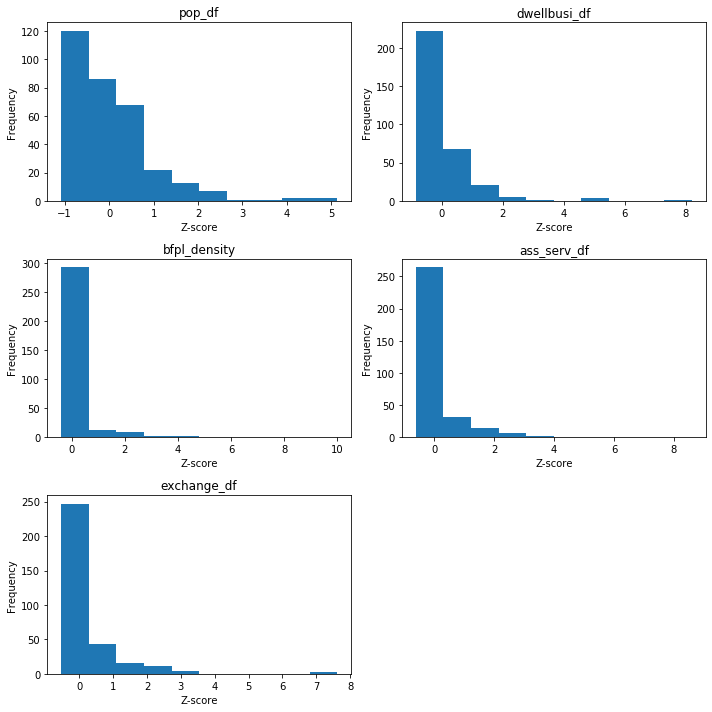

In [44]:
# Code for the function to retrieve name of dataframe from https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe
def df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

fig, axes = plt.subplots(3,2,figsize=(10,10))
computed_measures = [pop_df, dwellbusi_df, bfpl_density, ass_serv_df, exchange_df]

for m_type, ax in zip(computed_measures, axes.flatten()):
    ax.hist(m_type['z_score'])
    ax.set_xlabel('Z-score')
    ax.set_ylabel('Frequency')
    ax.title.set_text(df_name(m_type))

fig.delaxes(axes[2][1])
fig.tight_layout()

for df in computed_measures:
    print(df['z_score'].describe()['mean'] > df['z_score'].describe()['50%'])

### Fire Risk Score

Provided model:

$$fire_risk = S(z(population_density)+z(dwelling_&_business_density)+z(bfpl_density)−z(assistive_service_density))$$

Refined model:

$$fire_risk = S(0.1*z(population_density)+0.1*z(dwelling_&_business_density)+3*z(bfpl_density)−0.5*z(assistive_service_density-0.5*z(exchange_density))$$

While significantly reweighting the model towards bushfire prone land density, we justify these weightings because the other variables, even with decreased weighting, still contribute to construct relative risk based on areas that are:
- populated
- under-serviced
- contain bushfire prone land
- contain relatively greater amounts of the higher risk vegetation categories (based on weightings done in preprocessing work)

Without refinement, the model is too sensitive to populated urban areas which have zero BFPL and should not receive high risk scores. BFPL is the only natural environmental variable in the model and the model determines a risk assesment of an environmental phenomenon so this has informed the significant weighting allocated.

Though the nominated coefficients would appear to potentially overwhelm the model with this variable, the computed fire risk score rankings are different to the ranked order of bushfire prone land density alone, in particular there is different relative positioning outside the top quintile of BFPL density neighbourhoods. For example, the Manly - Fairlight area is ranked 38th in BFPL density, while its fire risk score is ranked 47th, which demonstrates the model recognizes the mitigation of the BFPL risk by the two negative determinants effective in that area. While there is a heavy bias imparted by BFPL density it does not dominate the model at the expense of the informative value of the other determinants.

#### Creation of dataframe with all measures
This is the first step for the creation of the computed risk score table. A series of pandas joins integrates the computed measures into a single dataframe while ensuring correct matching with area_id.

In [68]:
fire_risk_df = pop_df.copy()
fire_risk_df = fire_risk_df.drop(columns=['population','areasqkm16'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "pop_z_score"})

fire_risk_df = pd.merge(fire_risk_df, dwellbusi_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name_y'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "dwell_and_bus_z_score"})

fire_risk_df = pd.merge(fire_risk_df, bfpl_density, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','weighted_bfp_area'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "bf_z_score"})

fire_risk_df = pd.merge(fire_risk_df, ass_serv_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','health_care_and_social_assistance'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "asst_z_score"})

fire_risk_df = pd.merge(fire_risk_df, exchange_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','exchanges'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "exch_z_score"})

fire_risk_df = fire_risk_df.rename(columns={'area_name_x': 'area_name'})

fire_risk_df

,area_name,area_id,population_density,pop_z_score,dwell_and_bus_density,dwell_and_bus_z_score,bfpl_density,bf_z_score,assistive_service_density,asst_z_score,exchange_density,exch_z_score
0,Holsworthy Military Area,123021439,0.000000,-1.080651,0.000000,-0.845190,0.000481,4.319758,0.000000,-0.616531,0.000000,-0.535349
1,Potts Point - Woolloomooloo,117031333,16317.593037,5.131561,7967.925433,5.213205,0.000000,-0.401696,108.285930,2.436696,0.000000,-0.535349
2,Pyrmont - Ultimo,117031334,16148.997519,5.067376,7883.725609,5.149184,0.000000,-0.401696,111.982834,2.540934,0.000000,-0.535349
3,Darlinghurst,117031329,14487.104680,4.434682,7229.548372,4.651782,0.000000,-0.401696,326.759248,8.596765,1.166997,7.619263
4,Surry Hills,117031336,13722.272865,4.143506,7196.140991,4.626380,0.000000,-0.401696,156.487390,3.795783,0.000000,-0.535349
...,...,...,...,...,...,...,...,...,...,...,...,...
317,Singleton Region,106011113,1.209421,-1.080190,0.676873,-0.844676,0.000135,0.919926,0.002459,-0.616462,0.000246,-0.533631
318,Rookwood Cemetery,125011475,0.995025,-1.080272,3.980100,-0.842164,0.000000,-0.401696,0.000000,-0.616531,0.000000,-0.535349
319,Royal National Park,128021537,0.200957,-1.080574,0.050239,-0.845152,0.000287,2.417712,0.000000,-0.616531,0.000000,-0.535349
320,Blue Mountains - North,124011451,0.021847,-1.080642,0.015125,-0.845179,0.000103,0.607833,0.000000,-0.616531,0.001681,-0.523606


#### Calculation of fire risk scores

In [69]:
# Nominated coefficients to address confounding variable of population and the relative importance of BFPL
# 0.1(population_density)
# 0.1(dwelling_&_business_density)
# 3(bfpl_density)
# 0.5(assistive_service_density)
# 0.5(exchange_density)

fire_risk_df['untransformed'] = 0.1*(fire_risk_df['pop_z_score']) + 0.1*(fire_risk_df['dwell_and_bus_z_score']) + 3*(fire_risk_df['bf_z_score']) - 0.5*(fire_risk_df['asst_z_score']) - 0.5*(fire_risk_df['exch_z_score'])
fire_risk_df['fire_risk_score'] = fire_risk_df['untransformed'].apply(lambda x: sigmoid(x))
fire_risk_df.sort_values(by='fire_risk_score',ascending=False)

,area_name,area_id,population_density,pop_z_score,dwell_and_bus_density,dwell_and_bus_z_score,bfpl_density,bf_z_score,assistive_service_density,asst_z_score,exchange_density,exch_z_score,untransformed,fire_risk_score
225,Woronora Heights,128021609,1173.264487,-0.633981,419.136865,-0.526501,0.001060,9.995572,3.506088,-0.517674,0.000000,-0.535349,30.397179,1.000000
240,Narara,102011035,889.757339,-0.741914,296.932006,-0.619419,0.000894,8.369914,1.687851,-0.568941,0.000000,-0.535349,25.525754,1.000000
0,Holsworthy Military Area,123021439,0.000000,-1.080651,0.000000,-0.845190,0.000481,4.319758,0.000000,-0.616531,0.000000,-0.535349,13.342631,0.999998
277,Bayview - Elanora Heights,122021421,175.851230,-1.013703,73.688122,-0.789162,0.000441,3.921534,0.603874,-0.599505,0.000000,-0.535349,12.151741,0.999995
253,Chittaway Bay - Tumbi Umbi,102021047,640.730491,-0.836720,244.667042,-0.659158,0.000367,3.195117,2.000114,-0.560136,0.040819,-0.250121,9.840891,0.999947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,Kogarah,119041378,5507.951525,1.016262,2344.460963,0.937416,0.000000,-0.401696,118.484480,2.724254,0.450511,2.612683,-3.678188,0.024646
32,North Sydney - Lavender Bay,121041417,6173.735896,1.269730,5851.964062,3.604338,0.000000,-0.401696,136.335144,3.227571,0.522357,3.114717,-3.888824,0.020059
16,Bondi Junction - Waverly,118011341,7257.668225,1.682390,3259.491163,1.633157,0.000000,-0.401696,184.671475,4.590461,0.396291,2.233806,-4.285666,0.013578
18,Sydney - Haymarket - The Rocks,117031337,7222.713933,1.669083,11899.427028,8.202514,0.000000,-0.401696,283.458331,7.375853,1.164578,7.602359,-7.707033,0.000449


#### Integration of the computed measures and risk scores into the Postgres database

In [70]:
# Reduce the dataframe to: measures and risk score and normalised design (no 'area_name')
fire_risk_df = fire_risk_df.drop(columns=['area_name','pop_z_score','dwell_and_bus_z_score','bf_z_score','asst_z_score','exch_z_score','untransformed'])

# Table creation query
conn.execute("DROP TABLE IF EXISTS fire_risk")

score_create = '''CREATE TABLE fire_risk (
                     area_id VARCHAR NOT NULL,
                     population_density FLOAT NOT NULL,
                     dwell_and_bus_density FLOAT NOT NULL,
                     bfpl_density FLOAT NOT NULL,
                     assistive_service_density FLOAT NOT NULL,
                     exchange_density FLOAT NOT NULL,
                     fire_risk_score FLOAT NOT NULL,
                     CONSTRAINT fire_risk_pkey PRIMARY KEY (area_id),
                     CONSTRAINT fire_risk_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

conn.execute(score_create)

In [71]:
fire_risk_df.to_sql('fire_risk', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM fire_risk
LIMIT 1;""")

Data inserted into Table
(1, 7)
     area_id  population_density  dwell_and_bus_density  bfpl_density  assistive_service_density  exchange_density  fire_risk_score
0  123021439                 0.0                    0.0      0.000481                        0.0               0.0         0.999998


#### Generate Choropleth Map of Risk Scores

The following code is to generate a choropleth map of the fire risk scores across the New South Wales neighbourhoods studied. This is done directly from a query to the database. As a result, the geometry needs to be converted back from the WKTElement used by PostGIS to the geometry used by geopandas. (Note that for the map figure there is an implicit dependency on a library called descartes but this is available in the University server).

(322, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



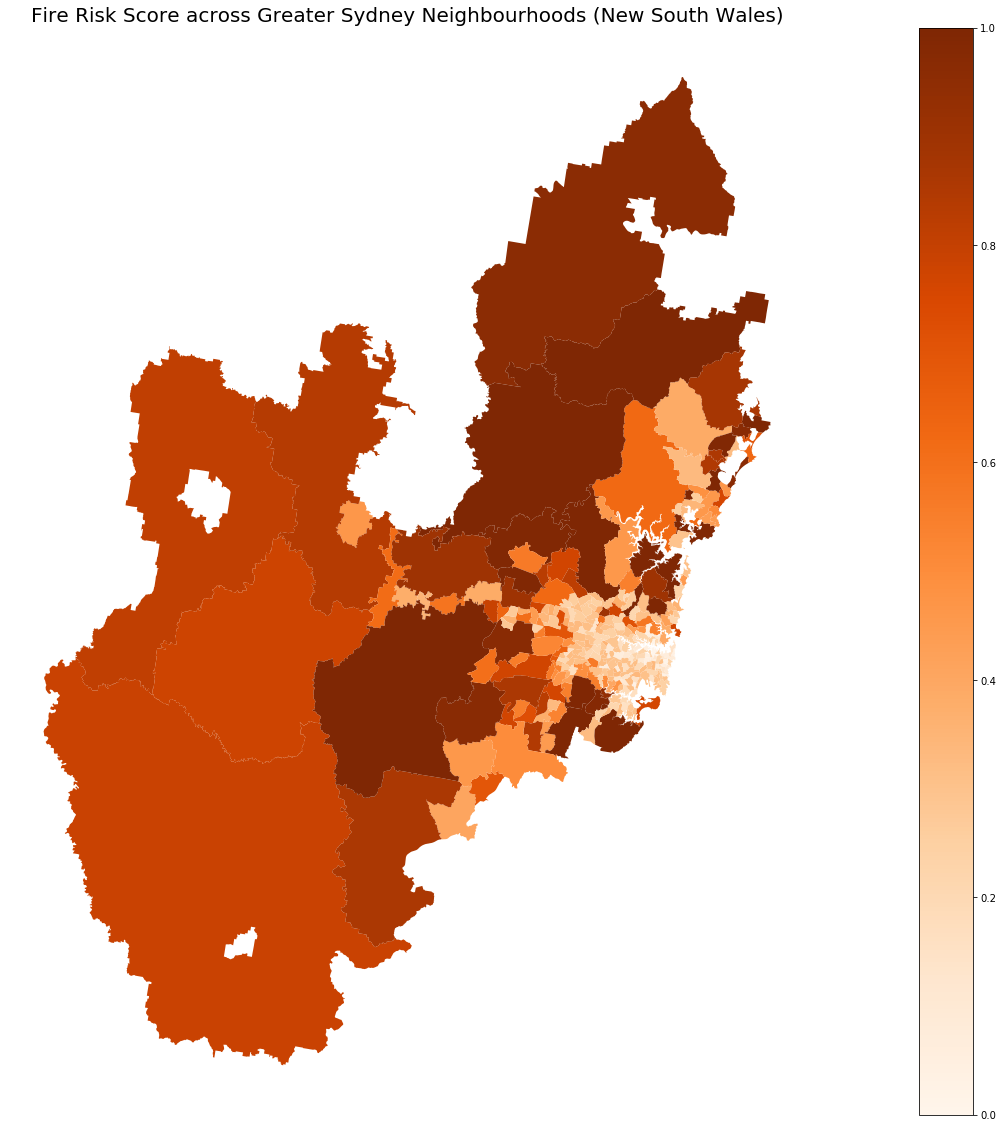

In [36]:
# WARNINGS PRODUCED WILL PREVENT PRINT OF SQL RESULT IN THE NOTEBOOK, HOWEVER DF WILL BE CREATED

response, risk_score_df = pgquery(conn, '''
SELECT area_id, fire_risk_score, ST_AsEWKT(geom::geometry)
FROM fire_risk AS fr INNER JOIN sa2_2016_aust AS sa ON(fr.area_id = sa.sa2_main16)
''') # First extract geometry as a WKTElement in string from SQL.

print(type(risk_score_df.st_asewkt[0])) 

def str_to_geom(x): # Removes unnecessary SRID and uses shapely wkt module to convert string to shapely geometry object
    x=x.replace('SRID=4283;', '')
    print(x)
    x=wkt.loads(x)
    return x

risk_score_df['geom'] = risk_score_df['st_asewkt'].map(lambda x: str_to_geom(x))
risk_score_df=risk_score_df.drop(columns=['st_asewkt'])

print(type(risk_score_df.geom[0]))

risk_score_df = GeoDataFrame(risk_score_df, crs='EPSG:4283', geometry=risk_score_df['geom'])
risk_score_df = risk_score_df.drop(columns=['geom'])

# Choropleth code
# Adapted from https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.set_title('Fire Risk Score across Greater Sydney Neighbourhoods (New South Wales)', fontdict={'fontsize':'20'})
ax.axis('off')
color = 'Oranges'
vmin, vmax = 0, 1
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A=[]
cbar = fig.colorbar(sm)
risk_score_df.plot('fire_risk_score', cmap=color, ax=ax)

### Linear Regression & Correlation

#### Analysis

For each combination of regressor i.e. median income and average monthly rent, and regressand i.e. fire risk score.

* Residuals plot is first generated to check for homescedasticity assumptions so that a linear model can be applied. 
* Ordinary-least-squares method of linear regression is applied, visualised in a scatter plot along with the predicted linear model. 
* A linear model summary which most importantly includes:
    * The r2 Score which gives us an indication of how much variance in the regressand can be explained by the regressor. 
    * The p-value which gives us an indication of the significance of the parameter. The null hypothesis is that the coefficient == 0. Therefore with a higher p-value we would retain this hypothesis and it would be evidence for no relationship. Correspondingly, a p-value below the alpha threshold would mean rejection of this hypothesis and would be statistically significant evidence of a non-zero value for the coefficient, suggesting a relationship between independent and dependent variables.
    * Pearson correlation coefficient which gives us an indication of the strength and direction of the linear relationship.

#### Fire Risk Score regressed on Median Income
Based on the following analysis it is unlikely that median income can effectively explain fire risk score.

* The residuals plot shows that the data meets the assumption of homoscedasticity and the residuals are fairly normally distributed.
* The r2 score is very low indicating that the variation in fire risk score isn't well explained by median income.
* The p value is > 0.05, supporting retention of the null hypothesis (coefficient == 0)
* The correlation value indicates a very weak negative linearity.

*(Note: due to the pgquery function output that is also produced, please scroll to the bottom of the output to see the charts inside the notebook (they are also included in Report))*

(322, 3)
       area_id  fire_risk_score  median_income
0    102011028         0.443903        46996.0
1    102011029         0.989128        42621.0
2    102011030         0.621319        42105.0
3    102011031         0.457740        43481.0
4    102011032         0.344117        45972.0
5    102011033         0.258389        47896.0
6    102011034         0.434413        41642.0
7    102011035         1.000000        46660.0
8    102011036         0.488230        45762.0
9    102011037         0.330747        45966.0
10   102011038         0.619318        43171.0
11   102011039         0.512163        46422.0
12   102011040         0.297585        40252.0
13   102011041         0.759690        47295.0
14   102011042         0.996133        42481.0
15   102011043         0.262672        43438.0
16   102021044         0.461954        42469.0
17   102021045         0.968605        42641.0
18   102021046         0.705788        41702.0
19   102021047         0.999947        45015.0
20  

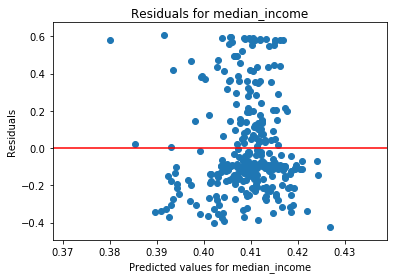

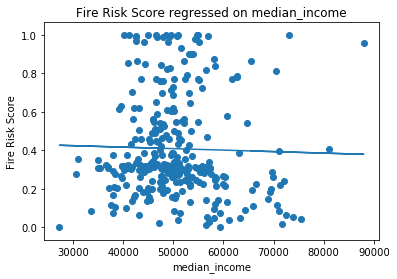

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2064
Date:                Tue, 25 May 2021   Prob (F-statistic):              0.650
Time:                        18:59:22   Log-Likelihood:                -22.689
No. Observations:                 314   AIC:                             49.38
Df Residuals:                     312   BIC:                             56.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4480      0.087      5.161      0.0

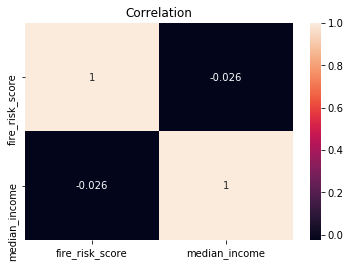

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
LinearReg('fire_risk_score', 'median_income')

#### Fire Risk Score regressed on Average Monthly Rent

Based on the following analysis it is likely that average monthly rent could be one factor that explains fire risk score.

* The residuals plot shows that the data meets the assumption of homoscedasticity and the residuals are fairly normally distributed.
* The r2 score is relatively low indicating that the variation in fire risk score is only partially explained by median income.
* The p value is < 0.05 (in fact too small for the OLS results summary to display beyond 0.000), allowing rejection of the null hypothesis that the coefficient == 0 and providing support for a non-zero coefficient for the variable.
* The correlation value indicates some negative linearity.

*(Note: due to the pgquery function output that is also produced, please scroll to the bottom of the output to see the charts inside the notebook (they are also included in Report))*

(322, 3)
       area_id  fire_risk_score  avg_monthly_rent
0    102011028         0.443903            1906.0
1    102011029         0.989128            1682.0
2    102011030         0.621319            1182.0
3    102011031         0.457740            1595.0
4    102011032         0.344117            1382.0
5    102011033         0.258389            1649.0
6    102011034         0.434413            1397.0
7    102011035         1.000000            1512.0
8    102011036         0.488230            1495.0
9    102011037         0.330747            1572.0
10   102011038         0.619318            1667.0
11   102011039         0.512163            2022.0
12   102011040         0.297585            1517.0
13   102011041         0.759690            1902.0
14   102011042         0.996133            1387.0
15   102011043         0.262672            1466.0
16   102021044         0.461954            1423.0
17   102021045         0.968605            1526.0
18   102021046         0.705788          

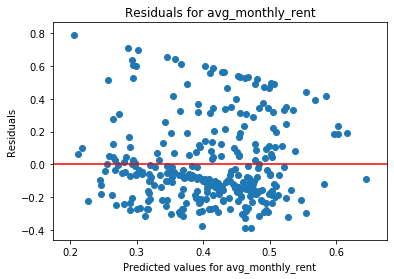

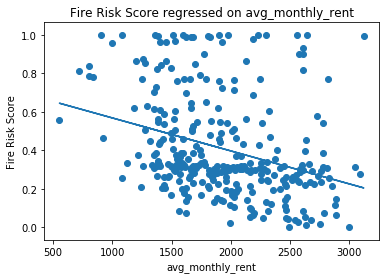

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     34.85
Date:                Tue, 25 May 2021   Prob (F-statistic):           9.40e-09
Time:                        18:59:37   Log-Likelihood:                -9.5115
No. Observations:                 310   AIC:                             23.02
Df Residuals:                     308   BIC:                             30.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7403      0.058     12.854      0.0

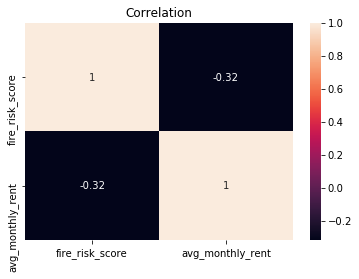

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
LinearReg('fire_risk_score', 'avg_monthly_rent')

In [58]:
# ------------------------------------
#     REMEMBER: DISCONNECT FROM DB!
# ------------------------------------

conn.close()
db.dispose()
print("disconnected")

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/eugenework/anaconda3/envs/data2001-py374/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/eugenework/anaconda3/envs/data2001-py374/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/eugenework/anaconda3/envs/data2001-py374/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: could not receive data from server: Operation timed out



disconnected
